# Want to play a Board Game?

In recent years board games have made a come back and have attracted lots of new players as well as a lot of new games. http://www.boardgamegeek.com is a huge website for board game lovers with thousands of reviews of board games from its users. 

This project looks at a dataset which was scraped by Sean Beck (https://github.com/ThaWeatherman). The goal of this project is to see the behaviour of board game reviews, whether the trend of board game reviewing has changed over the years and if machine learning can be applied to predict the average review of a given board game.

In [52]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [53]:
board_games = pd.read_csv("board_games.csv")

In [54]:
board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005,2,2,180,180,180,13,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012,2,5,150,60,150,12,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013,1,7,210,30,210,12,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006,2,4,240,240,240,12,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002,2,5,150,90,150,12,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


The dataset contains a lot of information about the boardgame, most columns are quite self-explanatory. One curious common is the "average weight" column. This is a subjective score from the user on how 'involved' the game is, how long it takes to learn the rules, how much thinking must be done while playing etc.

We are primarily interested in the "average rating" column.

## Exploratory Data Analysis

First we'll clean up the dataset a bit, dropping any rows with missing data, and dropping the columns we don't need.

In [55]:
board_games.dropna(axis=0,inplace=True)
board_games.drop(['id','type','name','bayes_average_rating'],axis=1, inplace=True)

As we are interested in the reviews given to board games, we must drop any game which has recieved no reviews.

In [56]:
board_games = board_games[board_games['users_rated'] > 0]

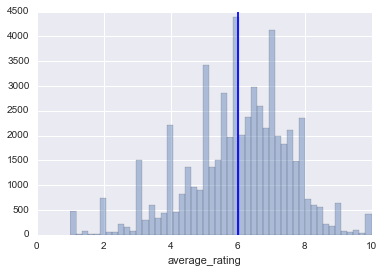

At first glance the data of average ratings looks like a slightly skewed normal distribution, although somewhat noisy. The mean rating for board games in this data set is 6.02, with a standard deviation of 1.58. This implies that a suitable error metric to make sense of this dataset might be a simple mean-squared error (MSE). Comparing this to the standard deviation will give us a good insight into the usefulness of our model.


In [57]:
sns.distplot(board_games['average_rating'],kde=False)
plt.axvline(board_games['average_rating'].mean())
plt.show()

print("At first glance the data of average ratings looks like a slightly skewed normal distribution, although somewhat noisy. The mean rating for board games in this data set is {mean:.2f}, with a standard deviation of {sd:.2f}. This implies that a suitable error metric to make sense of this dataset might be a simple mean-squared error (MSE). Comparing this to the standard deviation will give us a good insight into the usefulness of our model.".format(mean=board_games['average_rating'].mean(), sd=board_games['average_rating'].std()))

## Clustering

In [58]:
clusters.fit(board_games)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [59]:
game_mean = board_games.apply(np.mean,axis=1)
game_std = board_games.apply(np.std,axis=1)

labels = clusters.labels_
cluster_df = pd.DataFrame({"mean":game_mean ,"std": game_std,"labels":labels})

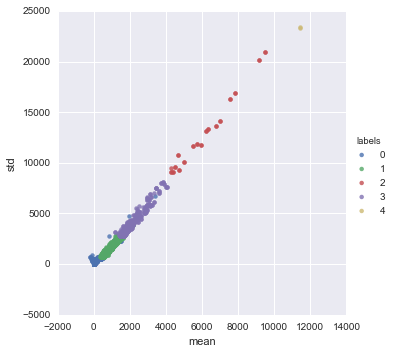

In [60]:
sns.lmplot('mean','std',data=cluster_df,hue='labels',fit_reg=False)
plt.show()

This dense clustering tells us that most games are quite similar. However there are a few games that stand out as having very large values (likely from the number of users that rated the game), this tells us that there are some games that have recieved tens of thousand of reviews, while most haven't been reviewed much.

## Do games that get lots of reviews always good games?

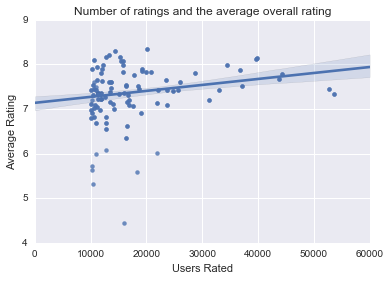

In [61]:
bg_big = board_games[board_games['users_rated'] > 10000]

sns.regplot(bg_big['users_rated'],bg_big['average_rating'],fit_reg=True)
plt.title('Number of ratings and the average overall rating')
plt.xlabel('Users Rated')
plt.ylabel('Average Rating')
plt.show()

It seems that there is a very slight correlation between the number of users who reviewed a game and the average rating. This isn't all that surprising since if a game is very popular, then it will attract lots of positive attention. If a game is unpopular, it's unlikely that thousands of people will leave negative reviews, they simply won't buy it. 

There is one interesting outlier on the above graph however, one game received over 15,000 reviews and has a terrible average of about 4.3! Let's see which game that is.

In [62]:
df = pd.read_csv("board_games.csv") # Oops! We need the name column again
worst_game = df[(df["users_rated"] > 10000) & (df["average_rating"] < 5)]['name'].values[0]
del df

In [63]:
print("The worst game among those with many reviews is {}".format(worst_game))

The worst game among those with many reviews is Monopoly


Wow! That's surprising! Perhaps too many family arguments have been caused by Monopoly...

## Are newer games better?

The "year" column of this dataset is a bit of a mess, with many years set to 0 and curiously a few with -3500. Let's ignore any games that have a year published before 1900.

In [72]:
valid_years = board_games[board_games['yearpublished'] > 1900]

valid_years['decade'] = (valid_years['yearpublished']//10)*10

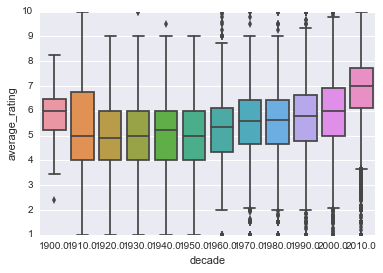

In [73]:
sns.boxplot(x='decade',y='average_rating',data=valid_years)
plt.show()

There seems to be a steady increase in the 'generosity' of board-game reviewers over the last 50 years. Have board games got better over the years or are people just more critical of older games?

## More machine learning - linear regression

We can apply some machine learning to see if the average rating can be predicted. We will train our initial linear regression model, then do some feature enginerring to see if our model can be improved.

In [74]:
correlations = numeric_columns.corr().sort('average_rating',ascending=False)
correlations['average_rating']

average_rating    1.000000
average_weight    0.351081
minage            0.210049
total_wanters     0.196566
total_wishers     0.171375
total_owners      0.137478
total_comments    0.123714
total_traders     0.119452
users_rated       0.112564
total_weights     0.109691
yearpublished     0.108461
playingtime       0.048994
maxplaytime       0.048994
minplaytime       0.043985
maxplayers       -0.008335
minplayers       -0.032701
Name: average_rating, dtype: float64

Now we can see that the average rating are the weight of the board game (remember weight is how 'involved' the game is). The minimum age of players is also correlated to the average rating, which suggests that games for adults are more highly rated than games for children.

In [79]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

train_x = numeric_columns[['average_weight', 'minage', 'total_wanters',
       'total_wishers', 'total_owners', 'total_comments', 'total_traders',
       'users_rated', 'total_weights','yearpublished']]
labels = numeric_columns['average_rating']

kf = KFold(n=numeric_columns.shape[0], n_folds=3, shuffle=True, random_state=8)

lr = LinearRegression()

accuracies = cross_val_score(lr, train_x, labels, 'mean_squared_error', cv=kf)

average_accuracy = np.abs(np.mean(accuracies))

print(average_accuracy)

2.09777633779


Our mean-squared error is quite close to our standard deviation, which means that our model isn't very useful and has little predictive power. We can do some feature engineering to see if this can be improved.
    

## Feature Engineering

In [77]:
board_games['players'] = board_games['maxplayers']-board_games['minplayers']

board_games['timerange'] = board_games['maxplaytime']-board_games['minplaytime']

board_games['ratingfraction'] = board_games['total_owners'] / board_games['users_rated']


In [80]:
train_x = board_games[['average_weight', 'minage', 'total_wanters',
       'total_wishers', 'total_owners', 'total_comments', 'total_traders',
       'users_rated', 'total_weights','players','timerange','ratingfraction','yearpublished']]
kf = KFold(n=numeric_columns.shape[0], n_folds=3, shuffle=True, random_state=8)

lr = LinearRegression()

accuracies = cross_val_score(lr, train_x, labels, 'mean_squared_error', cv=kf)

average_accuracy = np.abs(np.mean(accuracies))

print(average_accuracy)

2.03330767316


Well, there is some improvement, but not much. To improve this we could scrape more data, or take the feature engineering further. But ultimately I think machine learning is not of much use here. Still it was quite interesting to dive in to the dataset and see how reviews have changed for modern games and that Monopoly is quite universally hated!